# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import cm
# import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe

# %jsroot on
# %matplotlib qt
%matplotlib inline

In [2]:
sys.path.append('../python/')
from filterMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
from plotMethods import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events_20cmFOVL.root'
fileName = '/Users/noah-everett/Documents_non-iCloud/dsps/runs/calibration_2.42^3_10000gamma_1000events_0cmFOVL_+-1.00randPosNoSteps_randDir_v0.root'
# fileName = '../build/event.root'
# fileName = '../build/calibration.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'sensor_wall', 'relativePosition', 'relativePosition_binned', 'relativePosition_nBin', 'initialPosition', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['sensor_wall'            ] = get_photosensor_hits_photosensor_wall        (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
# df_hits['relativePosition'       ] = fixRotations_relative_signs(
#     np.array(df_hits['relativePosition'].to_list()), 
#     np.array(df_hits['sensor_wall'     ].to_list()),
#     handleZ=True
# )
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir,
                                                                                   x=np.array(df_hits['relativePosition'].to_list())[:,0], 
                                                                                   y=np.array(df_hits['relativePosition'].to_list())[:,1])
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir,
                                                                                   x=np.array(df_hits['relativePosition'].to_list())[:,0],
                                                                                   y=np.array(df_hits['relativePosition'].to_list())[:,1])
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)

df_hits['direction_relative_lens_0'          ] = get_photosensor_hits_direction_relative_lens(fileName, treeName, 0)
df_hits['direction_relative_lens_0'          ] = fixRotations_relative_signs(np.array(df_hits['direction_relative_lens_0'].to_list()), np.array(df_hits['sensor_wall'].to_list()), handleZ=False)
df_hits = df_hits[df_hits['direction_relative_lens_0'] != (0, 0, 0)]
df_hits['direction_relative_lens_0_theta'    ] = df_hits['direction_relative_lens_0'].apply(lambda x: np.arccos(x[2]/np.linalg.norm(x)))
df_hits['direction_relative_lens_0_phi'      ] = df_hits['direction_relative_lens_0'].apply(lambda x: np.arctan2(x[1], x[0]))

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_85969/4151121741.py:25: RuntimeWarning: invalid value encountered in scalar divide
  df_hits['direction_relative_lens_0_theta'    ] = df_hits['direction_relative_lens_0'].apply(lambda x: np.arccos(x[2]/np.linalg.norm(x)))


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)

# Filter Hits

In [7]:
# df_hits = df_hits[df_hits['sensor_wall'] == '+x']

search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Reconstruct Hit Angle

In [8]:
binned = True
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits, binned=binned)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta, binned=binned)
df_hits = make_phi(df_hits, binned=binned)
df_hits = make_reconstructedVector_direction(df_hits)

pdfFileName = '/Users/noah-everett/Documents_non-iCloud/dsps/hitRecoPDFs/PDFs_only000.pkl'
df_hits = make_recoDir_num(df_hits, pdfFileName)
df_hits = make_reconstructedVector_direction_num(df_hits)

df_hits = make_recoDir_ref(df_hits)
df_hits = make_reconstructedVector_direction_ref(df_hits)

100%|██████████| 26756/26756 [00:04<00:00, 5800.20it/s]


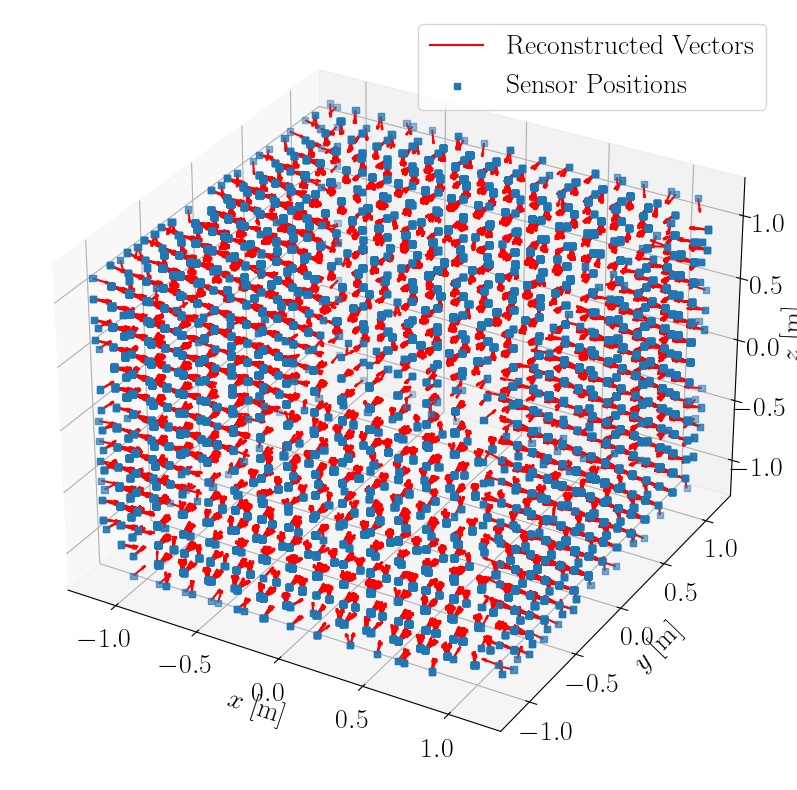

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
#            label='Reconstructed Points')
ax.quiver(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[2])/1000,
          df_hits['reconstructedVector_direction'].apply(lambda x: x[0]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[1]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[2]),
          label='Reconstructed Vectors',
          length=0.1,
          normalize=True,
          color='red')
ax.scatter(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[2])/1000,
           label='Sensor Positions',
           marker='s')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend()
plt.show()

# Reconstruct Hit Ideally with Initial Position

In [10]:
df_hits = make_reconstructedPoint_initial_distance(df_hits)
# print(df_hits.head())
# furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_initial_distance_r').index
# print(df_hits.loc[furthestPoints]['reconstructedPoint_initial_distance_r'])

# print()

df_hits = make_reconstructedPoint_initial_distance_num(df_hits)
df_hits.dropna(subset=['reconstructedPoint_initial_distance_r_num'], inplace=True)
# print(df_hits.head())
# furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_initial_distance_r_num').index
# print(df_hits.loc[furthestPoints]['reconstructedPoint_initial_distance_r_num'])

# print()

df_hits = make_reconstructedPoint_initial_distance_ref(df_hits)
# print(df_hits.head())
# furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_initial_distance_r_ref').index
# print(df_hits.loc[furthestPoints]['reconstructedPoint_initial_distance_r_ref'])

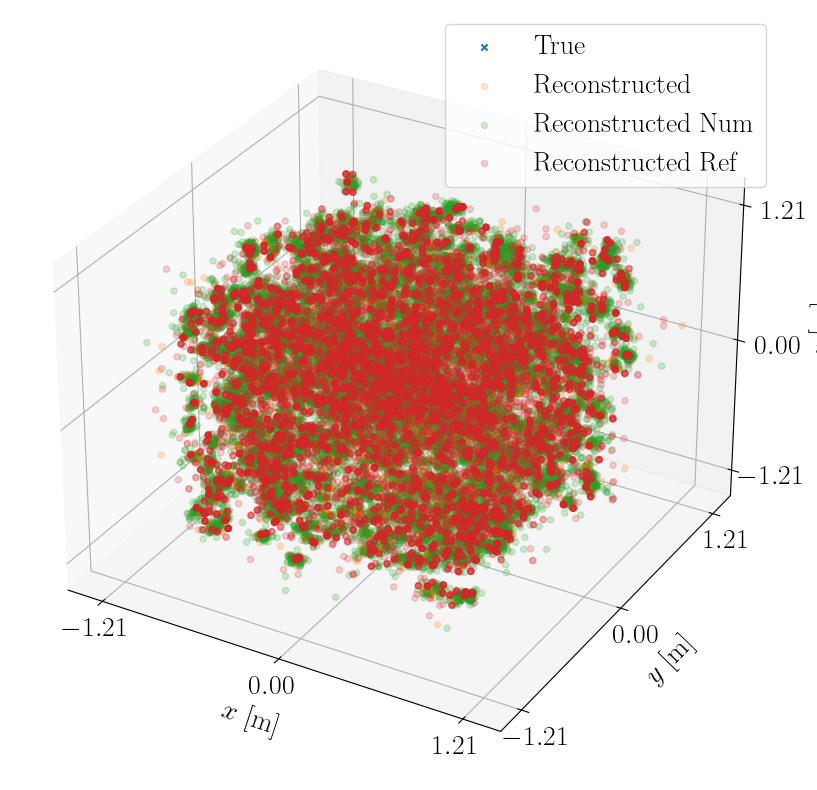

In [11]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.quiver(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
#           df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
#           df_hits['sensor_position'].apply(lambda x: x[2])/1000,
#           df_hits['reconstructedVector_direction'].apply(lambda x: x[0]), 
#           df_hits['reconstructedVector_direction'].apply(lambda x: x[1]), 
#           df_hits['reconstructedVector_direction'].apply(lambda x: x[2]),
#           label='Reconstructed Vectors',
#           length=0.1,
#           normalize=True,
#           color='red')
# ax.scatter(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
#            df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
#            df_hits['sensor_position'].apply(lambda x: x[2])/1000,
#            label='Sensor Positions',
#            marker='s')
ax.scatter(df_hits['initialPosition'].apply(lambda x: x[0])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[1])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.scatter(df_hits['reconstructedPoint_initial_distance_num'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_initial_distance_num'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_initial_distance_num'].apply(lambda x: x[2])/1000,
           label='Reconstructed Num',
           alpha=0.2)
ax.scatter(df_hits['reconstructedPoint_initial_distance_ref'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_initial_distance_ref'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_initial_distance_ref'].apply(lambda x: x[2])/1000,
           label='Reconstructed Ref',
           alpha=0.2)

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 17

percExtra=1.2
ax.set_xlim(-DETECTOR_SIZE_X_MM/2/1000*percExtra, DETECTOR_SIZE_X_MM/2/1000*percExtra)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2/1000*percExtra, DETECTOR_SIZE_Y_MM/2/1000*percExtra)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2/1000*percExtra, DETECTOR_SIZE_Z_MM/2/1000*percExtra)

n=3
ax.set_xticks(np.linspace(-DETECTOR_SIZE_X_MM/2/1000, DETECTOR_SIZE_X_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_yticks(np.linspace(-DETECTOR_SIZE_Y_MM/2/1000, DETECTOR_SIZE_Y_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_zticks(np.linspace(-DETECTOR_SIZE_Z_MM/2/1000, DETECTOR_SIZE_Z_MM/2/1000, n))#[[1,-2, n//2]])

ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=2)
ax.tick_params(axis='z', pad=10)

ax.legend(loc='upper right')
plt.show()

Analytical:
mean = 2.76
std = 3.06
1 sigma = 2.80
2 sigma = 6.40
3 sigma = 18.00

Numerical:
mean = 7.58
std = 6.75
1 sigma = 7.60
2 sigma = 19.60
3 sigma = 35.60

Reference:
mean = 9.59
std = 7.07
1 sigma = 10.40
2 sigma = 22.00
3 sigma = 36.80


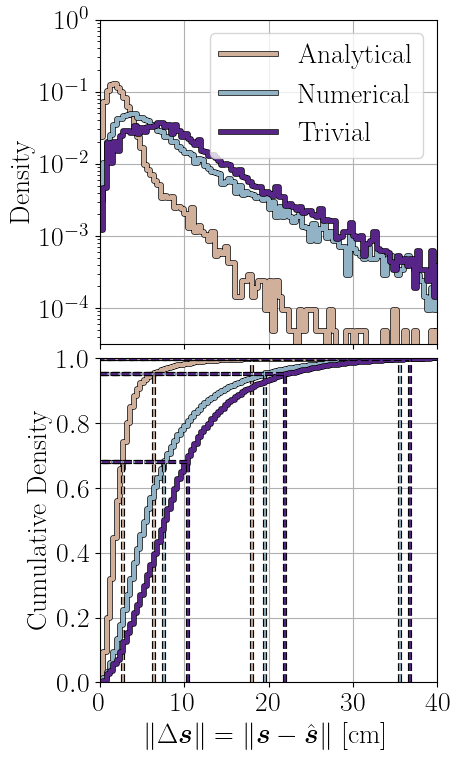

In [12]:
plotAna = True
plotNum = True
plotRef = True

twilight = cm.twilight(np.linspace(0,1,40))

xRange = (0, 40)
nBins = 40
# bins = np.linspace(xRange[0], xRange[1], nBins)
scale = 10

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
# fig, ax2 = plt.subplots(1, 2, figsize=(6, 5))
# ax1 = ax2.twinx()

if plotAna:
    # hist_ana, bins_ana, _ = ax1.hist(df_hits['reconstructedPoint_initial_distance_r']/scale, bins=bins, density=True, range=xRange, alpha=1, color=twilight[35,:], histtype='step', linestyle='-', linewidth=3, path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
    # hist_ana, bins_ana = np.histogram(df_hits['reconTrivialstructedPoint_initial_distance_r']/scale, bins=bins, density=True, range=xRange)
    PDF_ana, _, hist_ana, bins_ana = get_PDF(df_hits['reconstructedPoint_initial_distance_r']/scale, bins=None, range=xRange, addStart=False, addEnd=True)
    ax1.plot(bins_ana[:-1], hist_ana, color=twilight[35,:], label='Analytical', linewidth=3, drawstyle='steps-post', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
    # ax1.fill_between(bins[:-1], hist_ana, alpha=0.3, color=twilight[35,:], step='post', hatch='//')
    # hatch_between(bins_ana, hist_ana, ax=ax1, alpha=1, hatch='//', facecolor='none', edgecolor=twilight[35,:])
    # PDF_ana = np.cumsum(hist_ana*np.diff(bins_ana))
    ax2.plot(bins_ana[:-1], PDF_ana, color=twilight[35,:], label='Analytical', linewidth=3, drawstyle='steps-post', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])

    initial_mean_ana = np.mean(df_hits['reconstructedPoint_initial_distance_r']/scale)
    initial_std_ana = np.std(df_hits['reconstructedPoint_initial_distance_r']/scale)
    initial_sigma_1_ana = bins_ana[np.argmax(PDF_ana > 0.68)]
    initial_sigma_2_ana = bins_ana[np.argmax(PDF_ana > 0.95)]
    initial_sigma_3_ana = bins_ana[np.argmax(PDF_ana > 0.997)]

    ax2.plot([initial_sigma_1_ana, initial_sigma_1_ana, 0], [0, 0.68 , 0.68 ], color=twilight[35,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.plot([initial_sigma_2_ana, initial_sigma_2_ana, 0], [0, 0.95 , 0.95 ], color=twilight[35,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.plot([initial_sigma_3_ana, initial_sigma_3_ana, 0], [0, 0.997, 0.997], color=twilight[35,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
if plotNum:
    # hist_num, bins_num, _ = ax1.hist(df_hits['reconstructedPoint_initial_distance_r_num']/scale, bins=bins, density=True, range=xRange, alpha=1, color=twilight[5,:], histtype='step', linestyle='-', linewidth=3, path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
    # hist_num, bins_num = np.histogram(df_hits['reconstructedPoint_initial_distance_r_num']/scale, bins=bins, density=True, range=xRange)
    PDF_num, _, hist_num, bins_num = get_PDF(df_hits['reconstructedPoint_initial_distance_r_num']/scale, bins=None, range=xRange, addStart=False, addEnd=True)
    ax1.plot(bins_num[:-1], hist_num, color=twilight[5,:], label='Numerical', linewidth=3, drawstyle='steps-post', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
    # ax1.fill_between(bins[:-1], hist_num, alpha=0.3, color=twilight[5,:], step='post', hatch=r'//')
    # hatch_between(bins_num, hist_num, ax=ax1, alpha=1, hatch=r'\\', facecolor='none', edgecolor=twilight[5,:])
    # PDF_num = np.cumsum(hist_num*np.diff(bins_num))
    ax2.plot(bins_num[:-1], PDF_num, color=twilight[5,:], label='Numerical', linewidth=3, drawstyle='steps-post', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])

    initial_mean_num = np.mean(df_hits['reconstructedPoint_initial_distance_r_num']/scale)
    initial_std_num = np.std(df_hits['reconstructedPoint_initial_distance_r_num']/scale)
    initial_sigma_1_num = bins_num[np.argmax(PDF_num > 0.68)]
    initial_sigma_2_num = bins_num[np.argmax(PDF_num > 0.95)]
    initial_sigma_3_num = bins_num[np.argmax(PDF_num > 0.997)]

    ax2.plot([initial_sigma_1_num, initial_sigma_1_num, 0], [0, 0.68 , 0.68 ], color=twilight[5,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.plot([initial_sigma_2_num, initial_sigma_2_num, 0], [0, 0.95 , 0.95 ], color=twilight[5,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.plot([initial_sigma_3_num, initial_sigma_3_num, 0], [0, 0.997, 0.997], color=twilight[5,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
if plotRef:
    # hist_ref, bins_ref, _ = ax1.hist(df_hits['reconstructedPoint_initial_distance_r_ref']/scale, bins=bins, density=True, range=xRange, alpha=1, color=twilight[15,:], histtype='step', linestyle='-', linewidth=3, path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
    # hist_ref, bins_ref = np.histogram(df_hits['reconstructedPoint_initial_distance_r_ref']/scale, bins=bins, density=True, range=xRange)
    PDF_ref, _, hist_ref, bins_ref = get_PDF(df_hits['reconstructedPoint_initial_distance_r_ref']/scale, bins=None, range=xRange, addStart=False, addEnd=True)
    ax1.plot(bins_ref[:-1], hist_ref, color=twilight[15,:], label='Trivial', linewidth=3, drawstyle='steps-post', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
    # ax1.fill_between(bins[:-1], hist_ref, alpha=0.3, color=twilight[15,:], step='post', hatch='//')
    # hatch_between(bins_ref, hist_ref, ax=ax1, alpha=1, hatch='||', facecolor='none', edgecolor=twilight[15,:])
    # PDF_ref = np.cumsum(hist_ref*np.diff(bins_ref))
    ax2.plot(bins_ref[:-1], PDF_ref, color=twilight[15,:], label='Trivial', linewidth=3, drawstyle='steps-post', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])

    initial_mean_ref = np.mean(df_hits['reconstructedPoint_initial_distance_r_ref']/scale)
    initial_std_ref = np.std(df_hits['reconstructedPoint_initial_distance_r_ref']/scale)
    initial_sigma_1_ref = bins_ref[np.argmax(PDF_ref > 0.68)]
    initial_sigma_2_ref = bins_ref[np.argmax(PDF_ref > 0.95)]
    initial_sigma_3_ref = bins_ref[np.argmax(PDF_ref > 0.997)]

    ax2.plot([initial_sigma_1_ref, initial_sigma_1_ref, 0], [0, 0.68 , 0.68 ], color=twilight[15,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.plot([initial_sigma_2_ref, initial_sigma_2_ref, 0], [0, 0.95 , 0.95 ], color=twilight[15,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.plot([initial_sigma_3_ref, initial_sigma_3_ref, 0], [0, 0.997, 0.997], color=twilight[15,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])

if plotAna:
    print('Analytical:')
    print('mean = {:.2f}'.format(initial_mean_ana))
    print('std = {:.2f}'.format(initial_std_ana))
    print('1 sigma = {:.2f}'.format(initial_sigma_1_ana))
    print('2 sigma = {:.2f}'.format(initial_sigma_2_ana))
    print('3 sigma = {:.2f}'.format(initial_sigma_3_ana))
    print()
if plotNum:
    print('Numerical:')
    print('mean = {:.2f}'.format(initial_mean_num))
    print('std = {:.2f}'.format(initial_std_num))
    print('1 sigma = {:.2f}'.format(initial_sigma_1_num))
    print('2 sigma = {:.2f}'.format(initial_sigma_2_num))
    print('3 sigma = {:.2f}'.format(initial_sigma_3_num))
    print()
if plotRef:
    print('Reference:')
    print('mean = {:.2f}'.format(initial_mean_ref))
    print('std = {:.2f}'.format(initial_std_ref))
    print('1 sigma = {:.2f}'.format(initial_sigma_1_ref))
    print('2 sigma = {:.2f}'.format(initial_sigma_2_ref))
    print('3 sigma = {:.2f}'.format(initial_sigma_3_ref))

ax1.set_ylabel('Density')
ax1.set_yscale('log')
ax1.set_xlim(0, 40)#bins[-1])A
ax1.set_ylim(ymax=1e0)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Cumulative Density')
ax2.set_xlabel(r'$\norm{ \Delta \boldsymbol{s} }=\norm{\boldsymbol{s}-\hat{\boldsymbol{s}}}$ [cm]')

ax1.grid()
ax1.legend()
ax2.grid()

fig.tight_layout(h_pad=0)
fig.savefig('../figures/initialReconstructedPointDistance_t.pdf', bbox_inches='tight')
plt.show()

In [13]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# xlim = [0, np.pi/4]
# nBins = 100
# cs = [twilight[30,:], twilight[8,:]]
# cs1 = [twilight[35,:], twilight[4,:]]
# lw = 3

# bins = np.linspace(0, np.pi/4, nBins)

# error_ana = angle_between_vectors(
#     np.array(df_hits['direction_reco_cartesian'].to_list()),
#     np.array(df_hits['direction_true_cartesian'].to_list())
# )
# error_num = angle_between_vectors(
#     np.array(df_hits['direction_reco_cartesian_num'].to_list()),
#     np.array(df_hits['direction_true_cartesian'].to_list())
# )

# bins_ana, x_ana, _ = ax.hist(error_ana, bins=bins, histtype='step', lw=lw,
#         label=r'$\abs{\Delta d}_\text{Ana}=\arccos\hat{\boldsymbol{d}}_{\text{Ana}}\cdot \boldsymbol{d}$' if abs else r'$\Delta d_\text{Ana}=\arccos\hat{\boldsymbol{d}}_{\text{Ana}}\cdot \boldsymbol{d}$',
#         density=density, cumulative=True, color=cs[0], range=[xlim[0], xlim[1]+0.1])
# bins_num, x_num, _ = ax.hist(error_num, bins=bins, histtype='step', lw=lw,
#         label=r'$\abs{\Delta d}_\text{Num}=\arccos\hat{\boldsymbol{d}}_{\text{Num}}\cdot \boldsymbol{d}$' if abs else r'$\Delta d_\text{Num}=\arccos\hat{\boldsymbol{d}}_{\text{Num}}\cdot \boldsymbol{d}$',
#         density=density, cumulative=True, color=cs[1], range=[xlim[0], xlim[1]+0.1])

# sigma_1_ind_ana = np.argmin(np.abs(bins_ana - 0.68))
# sigma_2_ind_ana = np.argmin(np.abs(bins_ana - 0.95))
# sigma_3_ind_ana = np.argmin(np.abs(bins_ana - 0.99))

# sigma_1_ind_num = np.argmin(np.abs(bins_num - 0.68))
# sigma_2_ind_num = np.argmin(np.abs(bins_num - 0.95))
# sigma_3_ind_num = np.argmin(np.abs(bins_num - 0.99))

# ax.plot([0, x_ana[sigma_1_ind_ana], x_ana[sigma_1_ind_ana]], [0.68, 0.68, 0], 'r--', color=cs1[0], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# ax.plot([0, x_ana[sigma_2_ind_ana], x_ana[sigma_2_ind_ana]], [0.95, 0.95, 0], 'r--', color=cs1[0], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# # ax.plot([0, x_ana[sigma_3_ind_ana], x_ana[sigma_3_ind_ana]], [0.99, 0.99, 0], 'r--', lw=lw, color=cs[0], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

# ax.plot([0, x_num[sigma_1_ind_num], x_num[sigma_1_ind_num]], [0.68, 0.68, 0], 'b--', color=cs1[1], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# ax.plot([0, x_num[sigma_2_ind_num], x_num[sigma_2_ind_num]], [0.95, 0.95, 0], 'b--', color=cs1[1], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# # ax.plot([0, x_num[sigma_3_ind_num], x_num[sigma_3_ind_num]], [0.99, 0.99, 0], 'b--', lw=lw, color=cs[1], path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

# print('RMS Ana:', np.sqrt(np.mean(np.power(error_ana[~np.isnan(error_ana)], 2))))
# print('RMS Num:', np.sqrt(np.mean(np.power(error_num[~np.isnan(error_num)], 2))))

# ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
# ax.set_xlabel('Reconstruction Error [rad]')
# ax.set_ylabel('Cumulative Density' if density else 'Counts')
# ax.set_xlim(0, np.pi/4)
# ax.set_ylim(0, 1)
# ax.set_xticks(np.linspace(0, np.pi/4, 5))
# ax.set_xticklabels([r'$0$', r'$\pi/16$', r'$\pi/8$', r'$3\pi/16$', r'$\pi/4$'])
# # ax.set_yscale('log')
# ax.grid()

# fig.savefig('../figures/direction_error.pdf', bbox_inches='tight')
# plt.show()

In [14]:
df_hits['reconstructedPoint_initial_distance_r_x'] =  df_hits['initialPosition'].apply(lambda x: x[0]) - df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0])
df_hits['reconstructedPoint_initial_distance_r_y'] =  df_hits['initialPosition'].apply(lambda x: x[1]) - df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1])
df_hits['reconstructedPoint_initial_distance_r_z'] =  df_hits['initialPosition'].apply(lambda x: x[2]) - df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2])

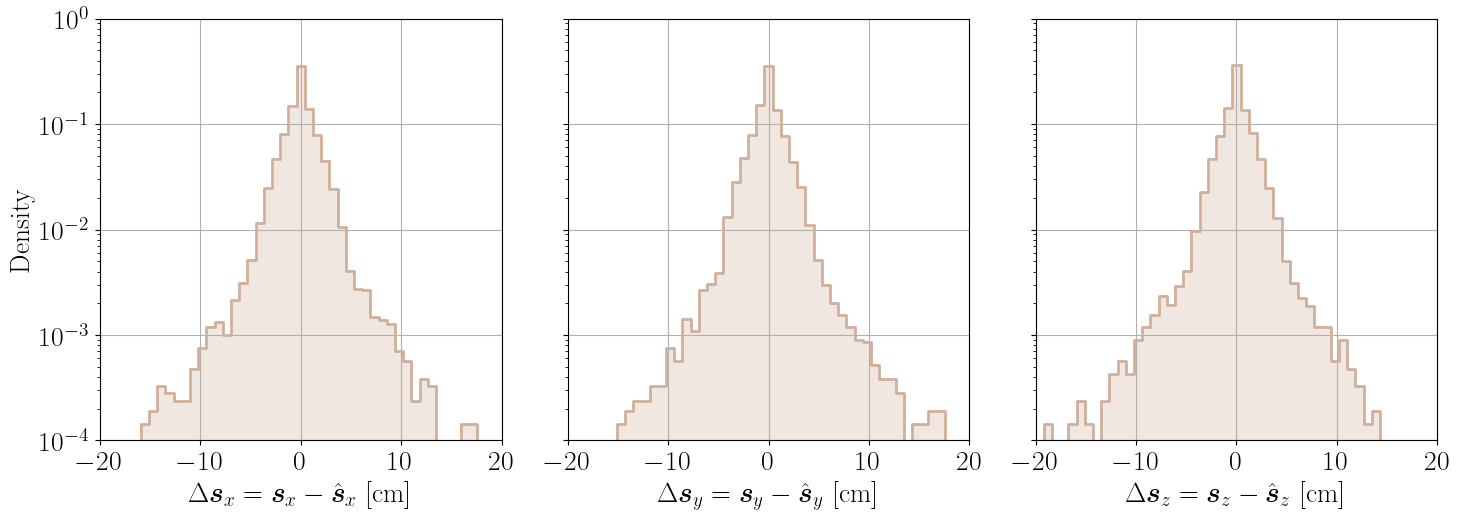

In [15]:
nBins = 50
xLim = 20
lw = 2
scale = 10

bins = np.linspace(-xLim, xLim, nBins)

_, hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_initial_distance_r_x']/scale, bins=bins)
_, hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_initial_distance_r_y']/scale, bins=bins)
_, hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_initial_distance_r_z']/scale, bins=bins)

bins_x = np.insert(bins_x, 0, bins_x[0] - np.diff(bins_x)[0])
bins_y = np.insert(bins_y, 0, bins_y[0] - np.diff(bins_y)[0])
bins_z = np.insert(bins_z, 0, bins_z[0] - np.diff(bins_z)[0])

scaled_hist_x = np.insert(scaled_hist_x, 0, 0)
scaled_hist_y = np.insert(scaled_hist_y, 0, 0)
scaled_hist_z = np.insert(scaled_hist_z, 0, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5.6))

axes[0].plot(bins_x[:-1], scaled_hist_x, alpha=1, color=twilight[35,:], drawstyle='steps-post', linewidth=lw)
axes[0].fill_between(bins_x[:-1], scaled_hist_x, alpha=0.3, color=twilight[35,:], step='post')#, hatch='//')
axes[0].set_xlabel(r'$\Delta \boldsymbol{s}_x=\boldsymbol{s}_{x}-\hat{\boldsymbol{s}}_{x}$ [cm]')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-xLim, xLim)
axes[0].set_ylim(1e-4, 1)
axes[0].set_yscale('log')
axes[0].grid()

axes[1].plot(bins_y[:-1], scaled_hist_y, alpha=1, color=twilight[35,:], drawstyle='steps-post', linewidth=lw)
axes[1].fill_between(bins_y[:-1], scaled_hist_y, alpha=0.3, color=twilight[35,:], step='post')#, hatch='xx')
axes[1].set_xlabel(r'$\Delta \boldsymbol{s}_y=\boldsymbol{s}_{y}-\hat{\boldsymbol{s}}_{y}$ [cm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-xLim, xLim)
axes[1].set_ylim(1e-4, 1)
axes[1].set_yscale('log')
axes[1].set_yticklabels([])
axes[1].grid()

axes[2].plot(bins_z[:-1], scaled_hist_z, alpha=1, color=twilight[35,:], drawstyle='steps-post', linewidth=lw)
axes[2].fill_between(bins_z[:-1], scaled_hist_z, alpha=0.3, color=twilight[35,:], step='post')#, hatch=r'\\')
axes[2].set_xlabel(r'$\Delta \boldsymbol{s}_z=\boldsymbol{s}_{z}-\hat{\boldsymbol{s}}_{z}$ [cm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-xLim, xLim)
axes[2].set_ylim(1e-4, 1)
axes[2].set_yscale('log')
axes[2].set_yticklabels([])
axes[2].grid()

fig.tight_layout()
fig.savefig('../figures/initialReconstructedPointDistance_xyz.pdf', bbox_inches='tight')
plt.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_85969/255943000.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes0.set_yticklabels(['' for i in axes0.get_yticks()])
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_85969/255943000.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes1.set_yticklabels(['' for i in axes1.get_yticks()])
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_85969/255943000.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes2.set_yticklabels(['' for i in axes2.get_yticks()])


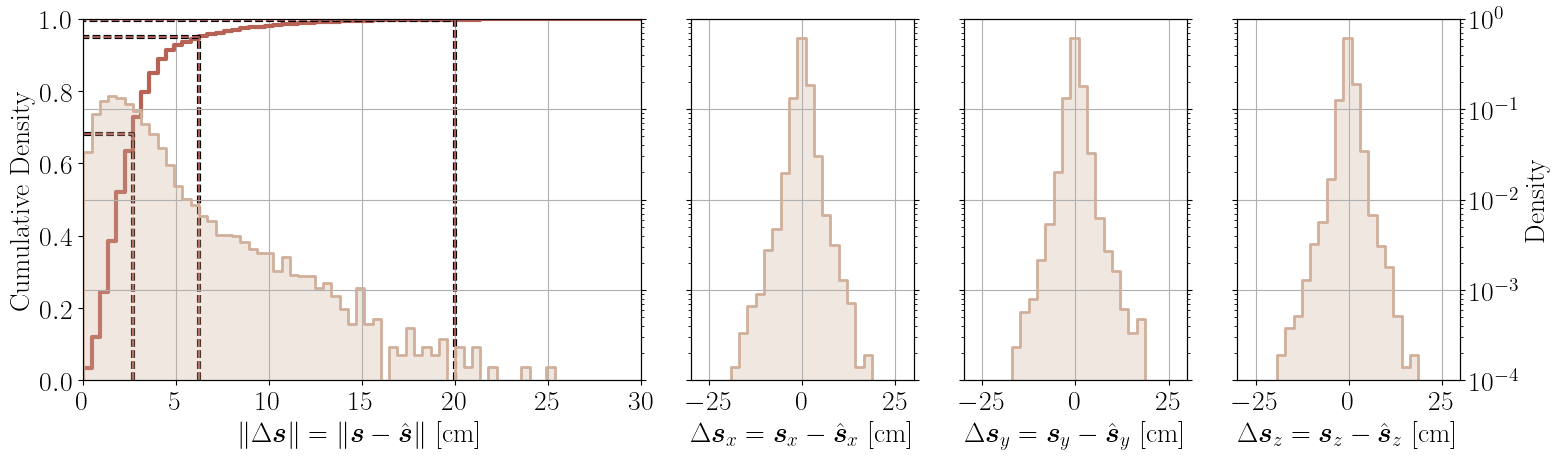

In [16]:
nBins = 80
xLim = 30
lw = 2
scale = 10
log = True
twilight = cm.twilight(np.linspace(0,1,40))

bins_xyz = np.linspace(np.min(
    np.concatenate([
        df_hits['reconstructedPoint_initial_distance_r_x']/scale,
        df_hits['reconstructedPoint_initial_distance_r_y']/scale,
        df_hits['reconstructedPoint_initial_distance_r_z']/scale
    ])), np.max(
    np.concatenate([
        df_hits['reconstructedPoint_initial_distance_r_x']/scale,
        df_hits['reconstructedPoint_initial_distance_r_y']/scale,
        df_hits['reconstructedPoint_initial_distance_r_z']/scale
    ])), nBins)

PDF, hist  , scaled_hist  , bins   = get_PDF(df_hits['reconstructedPoint_initial_distance_r'  ]/scale, nBins=nBins*3)
_  , hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_initial_distance_r_x']/scale, bins=bins_xyz)
_  , hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_initial_distance_r_y']/scale, bins=bins_xyz)
_  , hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_initial_distance_r_z']/scale, bins=bins_xyz)

PDF  =   np.insert(PDF   , 0, 0)
bins =   np.insert(bins  , 0, bins  [0] - np.diff(bins  )[0])
bins_x = np.insert(bins_x, 0, bins_x[0] - np.diff(bins_x)[0])
bins_y = np.insert(bins_y, 0, bins_y[0] - np.diff(bins_y)[0])
bins_z = np.insert(bins_z, 0, bins_z[0] - np.diff(bins_z)[0])

scaled_hist   = np.insert(scaled_hist  , 0, 0)
scaled_hist_x = np.insert(scaled_hist_x, 0, 0)
scaled_hist_y = np.insert(scaled_hist_y, 0, 0)
scaled_hist_z = np.insert(scaled_hist_z, 0, 0)

sigma_1 = bins[np.argmax(PDF > 0.68 )]
sigma_2 = bins[np.argmax(PDF > 0.95 )]
sigma_3 = bins[np.argmax(PDF > 0.997)]

scaled_hist_cum = [np.sum([scaled_hist[i] for i in range(j)]) for j in range(len(scaled_hist))]

fig, axes = plt.subplots(1, 4, figsize=(16, 5), gridspec_kw={'width_ratios': [2.5, 1, 1, 1]})
axes0 = axes[0].twinx()


# axes[0].set_position([0.1, 0.1, 0.25, 0.8])  # [left, bottom, width, height]
# axes[1].set_position([0.4, 0.1, 0.25, 0.8])
# axes[2].set_position([0.65, 0.1, 0.25, 0.8])
# axes[3].set_position([0.9, 0.1, 0.25, 0.8])

# axes[0].plot(bins[:-1], scaled_hist_cum, alpha=1, color=twilight[8,:], drawstyle='steps-post', linewidth=lw)
axes0.plot(bins[:-1], scaled_hist    , alpha=1, color=twilight[35,:], drawstyle='steps-post', linewidth=lw)
axes0.fill_between(bins[:-1], scaled_hist, alpha=0.3, color=twilight[35,:], step='post')#, hatch='//')
axes[0].plot(bins[:-1], PDF, color=twilight[30,:], label='Histogram', linewidth=3, drawstyle='steps-post')
axes[0].plot([sigma_1, sigma_1, 0], [0, 0.68 , 0.68 ], color=twilight[30,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
axes[0].plot([sigma_2, sigma_2, 0], [0, 0.95 , 0.95 ], color=twilight[30,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
axes[0].plot([sigma_3, sigma_3, 0], [0, 0.997, 0.997], color=twilight[30,:], linewidth=1.5, alpha=0.9, linestyle='--', path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
# axes[0].vlines([sigma_1, sigma_2, sigma_3], 0, [0.68, 0.95, 0.997], color=twilight[30,:], linestyle='--', linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
axes0.set_xlabel(r'$\norm{ \Delta \boldsymbol{s} }=\norm{\boldsymbol{s}-\hat{\boldsymbol{s}}}$ [cm]')
# axes1.set_ylabel('Density')
initTicks = axes[0].get_xticks().tolist()
initTickLabels = axes[0].get_xticklabels()
# initTicks.remove(20)
# axes[0].set_xticks(initTicks + [sigma_1, sigma_2, sigma_3])
# axes[0].set_xticklabels([str(int(i)) for i in initTicks] + ['{:.2f}'.format(sigma_1), '{:.2f}'.format(sigma_2), '{:.2f}'.format(sigma_3)])
# axes[0].set_xticklabels([str(int(i)) if i != 20 else '' for i in initTicks])
# axes1.set_xticks([sigma_1, sigma_2, sigma_3])
# axes1.set_xticklabels(['1 $\sigma$', '2 $\sigma$', '3 $\sigma$'])
# axes1.set_xticks(initTicks)
# axes1.set_xticklabels([str(int(i)) for i in initTicks])
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Cumulative Density')
# axes[0].set_yticklabels([])
# axes[0].set_yticks([])
if log:
    axes0.set_yscale('log')
axes0.set_ylim(1e-4, 1)
axes0.set_yticklabels(['' for i in axes0.get_yticks()])
axes0.set_xlim(0, 30)
axes0.grid()
axes[0].grid(axis='x')
axes[0].set_xlabel(r'$\norm{ \Delta \boldsymbol{s} }=\norm{\boldsymbol{s}-\hat{\boldsymbol{s}}}$ [cm]')

axes[1].plot(bins_x[:-1], scaled_hist_x, alpha=1, color=twilight[35,:], drawstyle='steps-post', linewidth=lw)
axes[1].fill_between(bins_x[:-1], scaled_hist_x, alpha=0.3, color=twilight[35,:], step='post')#, hatch='//')
axes[1].set_xlabel(r'$\Delta \boldsymbol{s}_x=\boldsymbol{s}_{x}-\hat{\boldsymbol{s}}_{x}$ [cm]')
# axes[1].set_ylabel('Density')
axes[1].set_xlim(-xLim, xLim)
axes[1].set_ylim(1e-4, 1)
if log:
    axes[1].set_yscale('log')
axes[1].set_yticklabels([])
axes[1].grid()
axes1 = axes[1].twinx()
if log:
    axes1.set_yscale('log')
axes1.set_ylim(1e-4, 1)
axes1.set_yticklabels(['' for i in axes1.get_yticks()])

axes[2].plot(bins_y[:-1], scaled_hist_y, alpha=1, color=twilight[35,:], drawstyle='steps-post', linewidth=lw)
axes[2].fill_between(bins_y[:-1], scaled_hist_y, alpha=0.3, color=twilight[35,:], step='post')#, hatch='xx')
axes[2].set_xlabel(r'$\Delta \boldsymbol{s}_y=\boldsymbol{s}_{y}-\hat{\boldsymbol{s}}_{y}$ [cm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-xLim, xLim)
axes[2].set_ylim(1e-4, 1)
if log:
    axes[2].set_yscale('log')
axes[2].set_yticklabels([])
axes[2].grid()
axes2 = axes[2].twinx()
if log:
    axes2.set_yscale('log')
axes2.set_ylim(1e-4, 1)
axes2.set_yticklabels(['' for i in axes2.get_yticks()])

axes[3].plot(bins_z[:-1], scaled_hist_z, alpha=1, color=twilight[35,:], drawstyle='steps-post', linewidth=lw)
axes[3].fill_between(bins_z[:-1], scaled_hist_z, alpha=0.3, color=twilight[35,:], step='post')#, hatch=r'\\')
axes[3].set_xlabel(r'$\Delta \boldsymbol{s}_z=\boldsymbol{s}_{z}-\hat{\boldsymbol{s}}_{z}$ [cm]')
# axes[3].set_ylabel('Normalized Counts')
axes[3].set_xlim(-xLim, xLim)
axes[3].set_ylim(1e-4, 1)
if log:
    axes[3].set_yscale('log')
axes[3].set_yticklabels([])
axes[3].grid()
axes3 = axes[3].twinx()
if log:
    axes3.set_yscale('log')
axes3.set_ylim(1e-4, 1)
# axes3.set_yticklabels(['' for i in axes3.get_yticks()])
axes3.set_ylabel('Density')

fig.tight_layout(h_pad=0.0)
fig.savefig('../figures/initialReconstructedPointDistance_txyz.pdf', bbox_inches='tight')
plt.show()

In [17]:
df_hits = make_relativeVector(df_hits)

18.781645832394627 226.74090004170088
Bin sizes: 4.159185084186124 2.0


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_85969/4240542357.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()/yscale


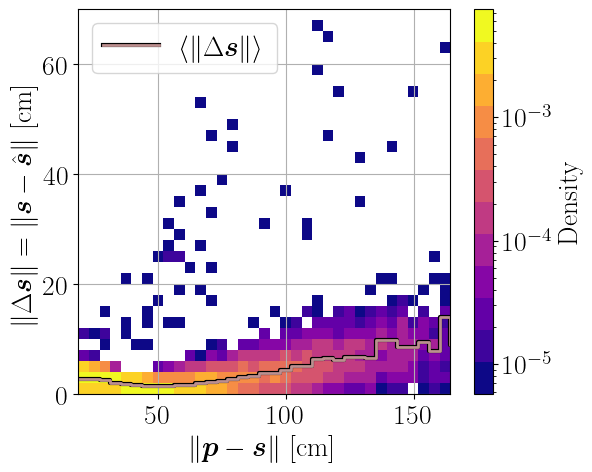

In [18]:
nBins = 50
colors = cm.plasma(np.linspace(0,1,12))
colorsmap = ListedColormap(colors)
colors = cm.twilight(np.linspace(0,1,40))

ymax = 70

yscale = 10
xscale = 10

print(df_hits['relativeVector_r'].min()/xscale, df_hits['relativeVector_r'].max()/xscale)

bins_x = np.linspace(df_hits['relativeVector_r'].min()/xscale, df_hits['relativeVector_r'].max()/xscale, nBins + 1)
# bins_x = np.linspace(16, 266, nBins + 1)
# bins_y = np.linspace(df_hits['reconstructedPoint_initial_distance_r'].min(), df_hits['reconstructedPoint_initial_distance_r'].max(), nBins + 1)
bins_y = np.linspace(0, ymax, 35+1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r']/xscale, bins=bins_x)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()/yscale

print("Bin sizes:", np.diff(bins_x)[0], np.diff(bins_y)[0])


fig, ax = plt.subplots(figsize=(6, 5))
hist = ax.hist2d(df_hits['relativeVector_r']/xscale, df_hits['reconstructedPoint_initial_distance_r']/yscale, bins=(bins_x,bins_y), norm=LogNorm(), cmap=colorsmap, density=True)
ax.plot(bins_x[:-1], average_recoPoint_r, marker='o', linestyle='-', color='rosybrown', drawstyle='steps-post', markersize=0, linewidth=2, label=r'$\langle \norm{ \Delta\boldsymbol{s} } \rangle$', path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.set_xlabel(r'$ \norm{ \boldsymbol{p} - \boldsymbol{s} }$ [cm]')
ax.set_ylabel(r'$ \norm{ \Delta \boldsymbol{s} }=\norm{\boldsymbol{s}-\hat{\boldsymbol{s}}}$ [cm]')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_title('Relative Vector vs Reconstructed Point Initial Distance')
index = np.abs(bins_x - 166).argmin()
ax.set_xlim(xmax=bins_x[index])
ax.set_ylim(0, ymax)

ax.grid()
ax.legend(loc='upper left')

cbar = plt.colorbar(hist[3], ax=ax)
# cbar.set_label('Density/5 cm/2 cm')
cbar.set_label('Density')

fig.savefig('../figures/relativeVector_vs_reconstructedPointInitialDistance.pdf', bbox_inches='tight')
plt.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_85969/4004114577.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()


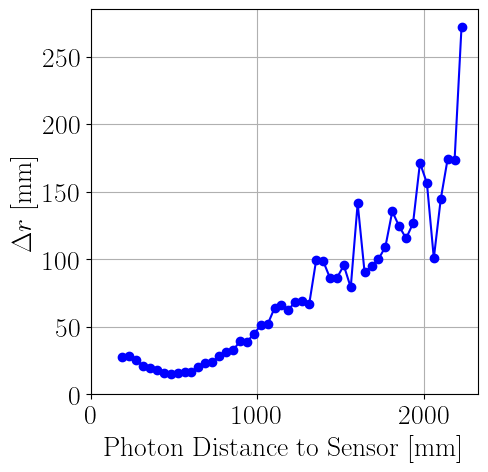

In [19]:
num_bins = 50
bins = np.linspace(df_hits['relativeVector_r'].min(), df_hits['relativeVector_r'].max(), num_bins + 1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r'], bins=bins)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()

fileName = '../figures/photonDistanceToSensor_vs_recoPointInitialDistance_10cm.pkl'
data = {
    'bins': bins,
    'average_recoPoint_r': average_recoPoint_r
}
with open(fileName, 'wb') as f:
    pkl.dump(data, f)

pkl_data = pkl.load(open(fileName, 'rb'))
bins = pkl_data['bins']
average_recoPoint_r = pkl_data['average_recoPoint_r']

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bins[:-1], average_recoPoint_r, marker='o', linestyle='-', color='b')
ax.set_xlabel(r'Photon Distance to Sensor [mm]')
ax.set_ylabel(r'$\Delta r$ [mm]')
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
# ax.set_aspect('equal')
ax.grid()
plt.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_85969/4035684470.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()


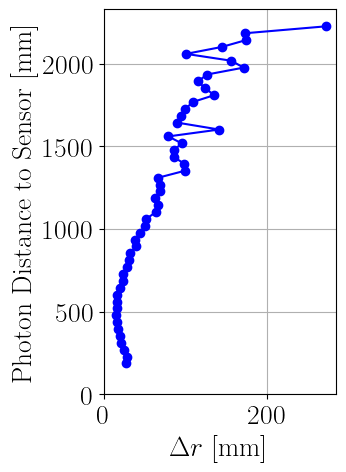

In [20]:
num_bins = 50
bins = np.linspace(df_hits['relativeVector_r'].min(), df_hits['relativeVector_r'].max(), num_bins + 1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r'], bins=bins)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()

fig, ax = plt.subplots(figsize=(3, 5))
ax.plot(average_recoPoint_r, bins[:-1], marker='o', linestyle='-', color='b')
ax.set_ylabel(r'Photon Distance to Sensor [mm]')
ax.set_xlabel(r'$\Delta r$ [mm]')
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.grid()

plt.show()

In [21]:
raise Exception('Stop here')

Exception: Stop here

# Performance Reconstruction Methods With Respect to Filter Parameters

In [ ]:
print(search_radius)
print(search_number)
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(primary_sigma_1))
print('{:.2f}'.format(primary_sigma_2))
print('{:.2f}'.format(primary_sigma_3))
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(initial_sigma_1))
print('{:.2f}'.format(initial_sigma_2))
print('{:.2f}'.format(initial_sigma_3))
print()
print('[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'
        .format(search_radius, search_number, primary_mean, primary_std, primary_sigma_1, primary_sigma_2, primary_sigma_3, initial_mean, initial_std, initial_sigma_1, initial_sigma_2, initial_sigma_3))

0
0


KeyError: 'reconstructedPoint_primary_distance_r'

# Reconstruct Hit With Time

In [ ]:
df_hits = make_reconstructedVector_time(df_hits, C_XENON_MM_PER_NS)
df_hits = make_reconstructedPoint_time(df_hits)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
           label='Reconstructed')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
plt.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_22168/1246560983.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Error in callback <function _draw_all_if_interactive at 0x10c229580> (for post_execute):


KeyboardInterrupt: 

# Reconstruct Hit Ideally with Primary Position

In [ ]:
df_hits = make_reconstructedPoint_primary_distance(df_hits, df_primary)

furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_primary_distance_r').index
print(df_hits.loc[furthestPoints]['reconstructedPoint_primary_distance_r'])

  1%|          | 30/3202 [00:17<31:24,  1.68it/s]


KeyboardInterrupt: 

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_3890/3053773788.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


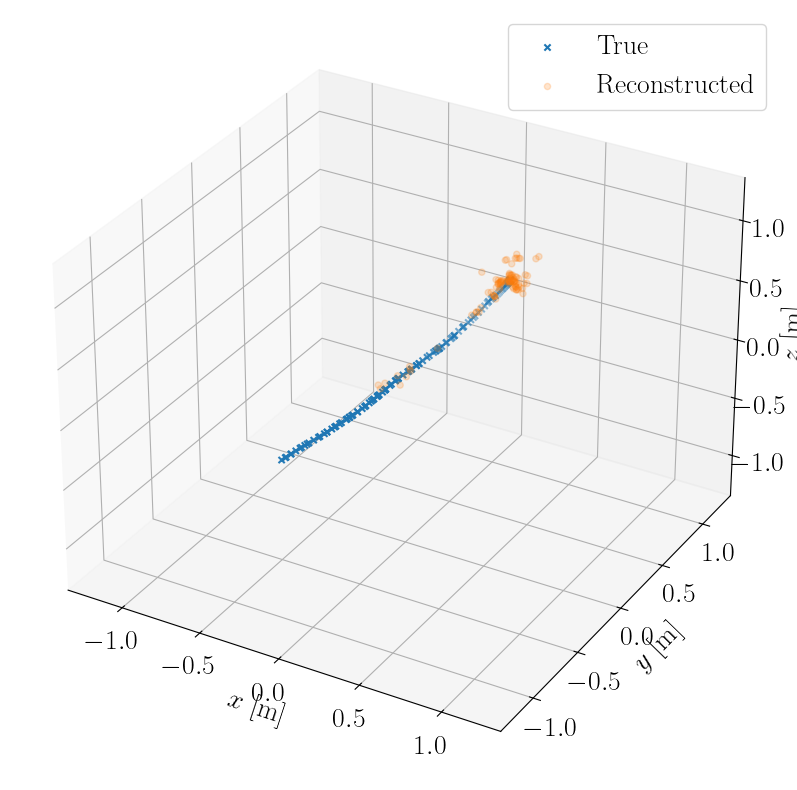

In [ ]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
plt.show()

mean = 6.42
std = 7.12
1 sigma = 5.81
2 sigma = 23.96
3 sigma = 32.87


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_3890/3759327104.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

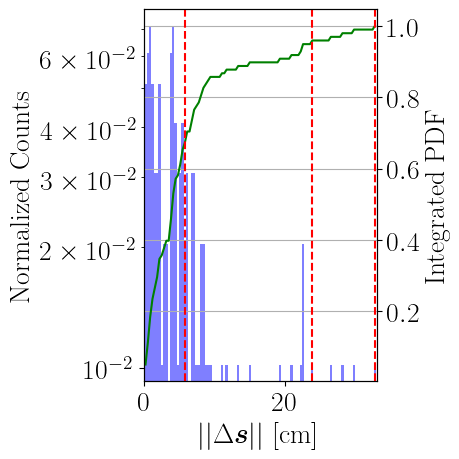

In [ ]:
scale = 10

PDF, hist, scaled_hist, bins = get_PDF(df_hits['reconstructedPoint_primary_distance_r']/scale, nBins=100)
primary_mean = np.mean(df_hits['reconstructedPoint_primary_distance_r']/scale)
primary_std = np.std(df_hits['reconstructedPoint_primary_distance_r']/scale)
primary_sigma_1 = get_CSP('1 sigma', PDF=PDF, bins=bins)
primary_sigma_2 = get_CSP('2 sigma', PDF=PDF, bins=bins)
primary_sigma_3 = get_CSP('3 sigma', PDF=PDF, bins=bins)

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$|| \Delta \boldsymbol{s} ||$ [cm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
ax2.plot(bins[:-1], PDF, color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

print('mean = {:.2f}'.format(primary_mean))
print('std = {:.2f}'.format(primary_std))
print('1 sigma = {:.2f}'.format(primary_sigma_1))
print('2 sigma = {:.2f}'.format(primary_sigma_2))
print('3 sigma = {:.2f}'.format(primary_sigma_3))

ax2.axvline(primary_sigma_1, color='red', linestyle='--', label='1 Sigma')
ax2.axvline(primary_sigma_2, color='red', linestyle='--', label='2 Sigma')
ax2.axvline(primary_sigma_3, color='red', linestyle='--', label='3 Sigma')
ax2.grid()

fig.tight_layout()
plt.show()

In [ ]:
df_hits['reconstructedPoint_primary_distance_r_x'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0]) - df_hits['initialPosition'].apply(lambda x: x[0])
df_hits['reconstructedPoint_primary_distance_r_y'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1]) - df_hits['initialPosition'].apply(lambda x: x[1])
df_hits['reconstructedPoint_primary_distance_r_z'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2]) - df_hits['initialPosition'].apply(lambda x: x[2])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_3890/4023523470.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

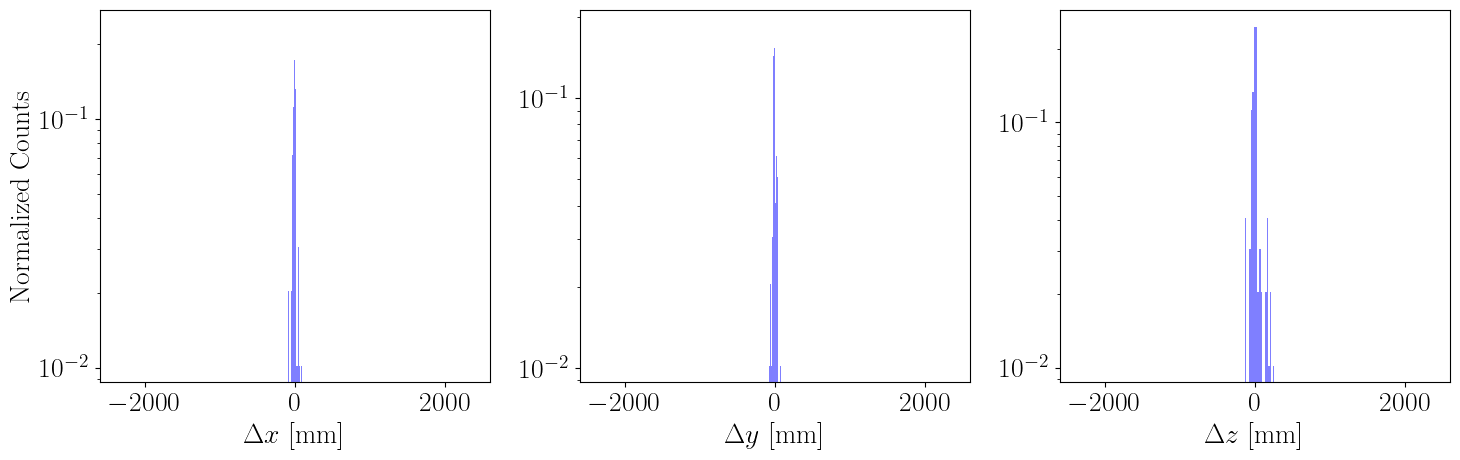

In [ ]:
nBins = 20

_, hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_primary_distance_r_x'], nBins=nBins)
_, hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_primary_distance_r_y'], nBins=nBins)
_, hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_primary_distance_r_z'], nBins=nBins)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(bins_x[:-1], scaled_hist_x, width=np.diff(bins_x), alpha=0.5, color='blue')
axes[0].set_xlabel(r'$\Delta x$ [mm]')
axes[0].set_ylabel('Normalized Counts')
axes[0].set_xlim(-2600, 2600)
axes[0].set_yscale('log')

axes[1].bar(bins_y[:-1], scaled_hist_y, width=np.diff(bins_y), alpha=0.5, color='blue')
axes[1].set_xlabel(r'$\Delta y$ [mm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-2600, 2600)
axes[1].set_yscale('log')

axes[2].bar(bins_z[:-1], scaled_hist_z, width=np.diff(bins_z), alpha=0.5, color='blue')
axes[2].set_xlabel(r'$\Delta z$ [mm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-2600, 2600)
axes[2].set_yscale('log')

fig.tight_layout()
plt.show()